<a href="https://colab.research.google.com/github/Jess08-Mathew/Jess/blob/main/DL_Proj_ETE3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
# Updated path configuration
base_path = "/content/drive/MyDrive/İNME VERİ SETİ/YarısmaVeriSeti_1_Oturum"
png_path = os.path.join(base_path, "PNG")
masks_path = os.path.join(base_path, "MASKS")
overlay_path = os.path.join(base_path, "OVERLAY")

In [ ]:
# Verify paths
print("PNG path exists:", os.path.exists(png_path))
print("Masks path exists:", os.path.exists(masks_path))
print("Overlay path exists:", os.path.exists(overlay_path))

PNG path exists: True
Masks path exists: True
Overlay path exists: True


In [ ]:
# Visualization code
png_files = sorted(os.listdir(png_path))[:5]
mask_files = sorted(os.listdir(masks_path))[:5]
overlay_files = sorted(os.listdir(overlay_path))[:5]

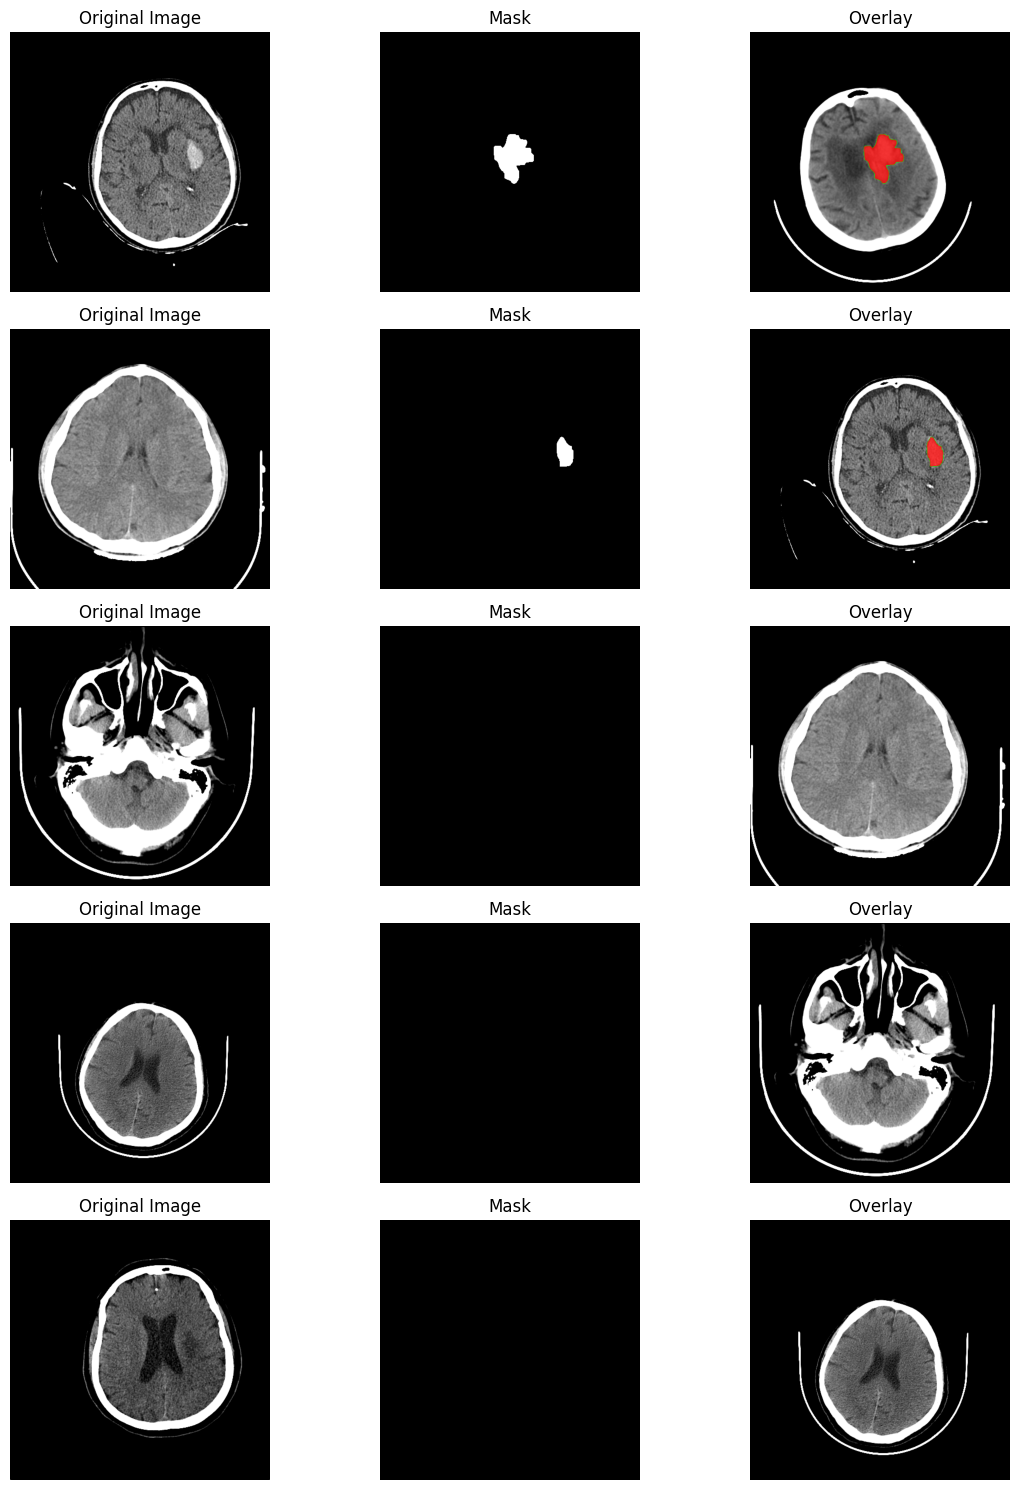

In [ ]:
!pip install opencv-python
import cv2 # Import the OpenCV (cv2) module

fig, axes = plt.subplots(5, 3, figsize=(12, 15))
for i in range(5):
    img = cv2.imread(os.path.join(png_path, png_files[i]))
    mask = cv2.imread(os.path.join(masks_path, mask_files[i]), cv2.IMREAD_GRAYSCALE)
    overlay = cv2.imread(os.path.join(overlay_path, overlay_files[i]))

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    axes[i, 0].imshow(img)
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(mask, cmap="gray")
    axes[i, 1].set_title("Mask")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(overlay)
    axes[i, 2].set_title("Overlay")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
def load_images_and_masks(image_folder, mask_folder, image_size=(256, 256)):
    images = []
    masks = []

    image_files = sorted(os.listdir(image_folder))
    mask_files = sorted(os.listdir(mask_folder))

    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_folder, img_file)
        mask_path = os.path.join(mask_folder, mask_file)

        img = Image.open(img_path).convert("L").resize(image_size)
        mask = Image.open(mask_path).convert("L").resize(image_size)

        img = np.array(img) / 255.0
        mask = np.array(mask) / 255.0

        images.append(np.expand_dims(img, axis=-1))
        masks.append(np.expand_dims(mask, axis=-1))

    return np.array(images), np.array(masks)

In [ ]:
# Load data
images, masks = load_images_and_masks(png_path, masks_path)

# GPU configuration
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPUs Available:", gpus)
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found. Running on CPU.")

GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

In [ ]:
def multihead_attention_block(inputs, key_dim, num_heads):
    """Adds a multi-head attention block"""
    attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(inputs, inputs)
    attention = layers.LayerNormalization(epsilon=1e-6)(attention + inputs)
    return attention

In [ ]:
def unet_model(input_size=(256, 256, 1)):
    inputs = tf.keras.Input(input_size)

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation="relu", padding="same")(inputs)
    conv1 = layers.Conv2D(64, 3, activation="relu", padding="same")(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation="relu", padding="same")(pool1)
    conv2 = layers.Conv2D(128, 3, activation="relu", padding="same")(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bridge with attention
    conv3 = layers.Conv2D(256, 3, activation="relu", padding="same")(pool2)
    conv3 = layers.Conv2D(256, 3, activation="relu", padding="same")(conv3)

    # Attention mechanism
    reshaped_conv3 = layers.Reshape((-1, 256))(conv3)
    attention_conv3 = multihead_attention_block(reshaped_conv3, key_dim=256//4, num_heads=4)
    attention_conv3 = layers.Reshape((conv3.shape[1], conv3.shape[2], 256))(attention_conv3)
     # Decoder
    up1 = layers.UpSampling2D(size=(2, 2))(attention_conv3)
    concat1 = layers.concatenate([conv2, up1], axis=-1)
    conv4 = layers.Conv2D(128, 3, activation="relu", padding="same")(concat1)
    conv4 = layers.Conv2D(128, 3, activation="relu", padding="same")(conv4)

    up2 = layers.UpSampling2D(size=(2, 2))(conv4)
    concat2 = layers.concatenate([conv1, up2], axis=-1)
    conv5 = layers.Conv2D(64, 3, activation="relu", padding="same")(concat2)
    conv5 = layers.Conv2D(64, 3, activation="relu", padding="same")(conv5)

    outputs = layers.Conv2D(1, 1, activation="sigmoid")(conv5)

    return tf.keras.Model(inputs, outputs)

In [ ]:
# Create and compile model
model = unet_model(input_size=(256, 256, 1))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 4096, 256)      │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 4096, 256)      │        263,168 │ reshape[0][0],         │
│ (MultiHeadAttention)      │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 4096, 256)      │              0 │ multi_head_attention[… │
│                           │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 4096, 256)      │            512 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 64, 64, 256)    │              0 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 128, 128, 256)  │              0 │ reshape_1[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 128, 128, 384)  │              0 │ conv2d_3[0][0],        │
│                           │                        │                │ up_sampling2d[0][0]    │
├──────────────────────

 Total params: 2,145,665 (8.19 MB)

 Trainable params: 2,145,665 (8.19 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=8,
    epochs=5,
    verbose=1
)

Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.9731 - loss: 0.1288 - val_accuracy: 0.9942 - val_loss: 0.0115
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 67s 530ms/step - accuracy: 0.9955 - loss: 0.0094 - val_accuracy: 0.9942 - val_loss: 0.0099
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 535ms/step - accuracy: 0.9962 - loss: 0.0066 - val_accuracy: 0.9942 - val_loss: 0.0101
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 547ms/step - accuracy: 0.9964 - loss: 0.0079 - val_accuracy: 0.9942 - val_loss: 0.0106
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 535ms/step - accuracy: 0.9961 - loss: 0.0082 - val_accuracy: 0.9942 - val_loss: 0.0099


In [ ]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()

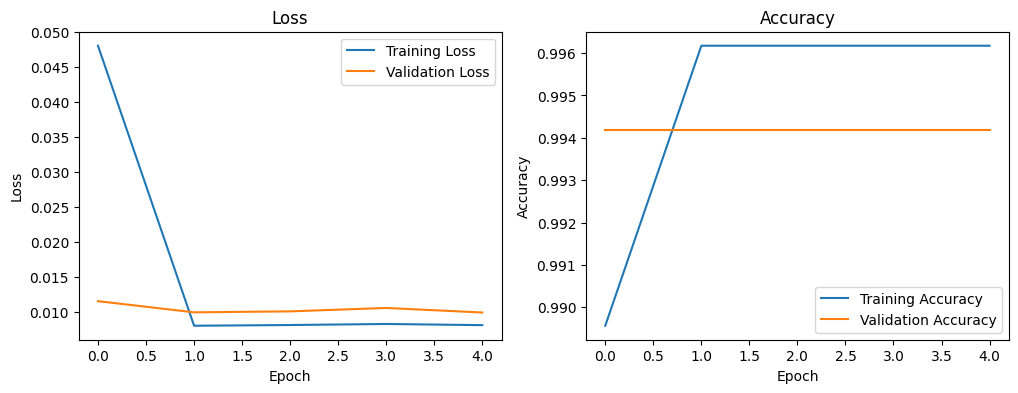

In [ ]:
plot_training_history(history)

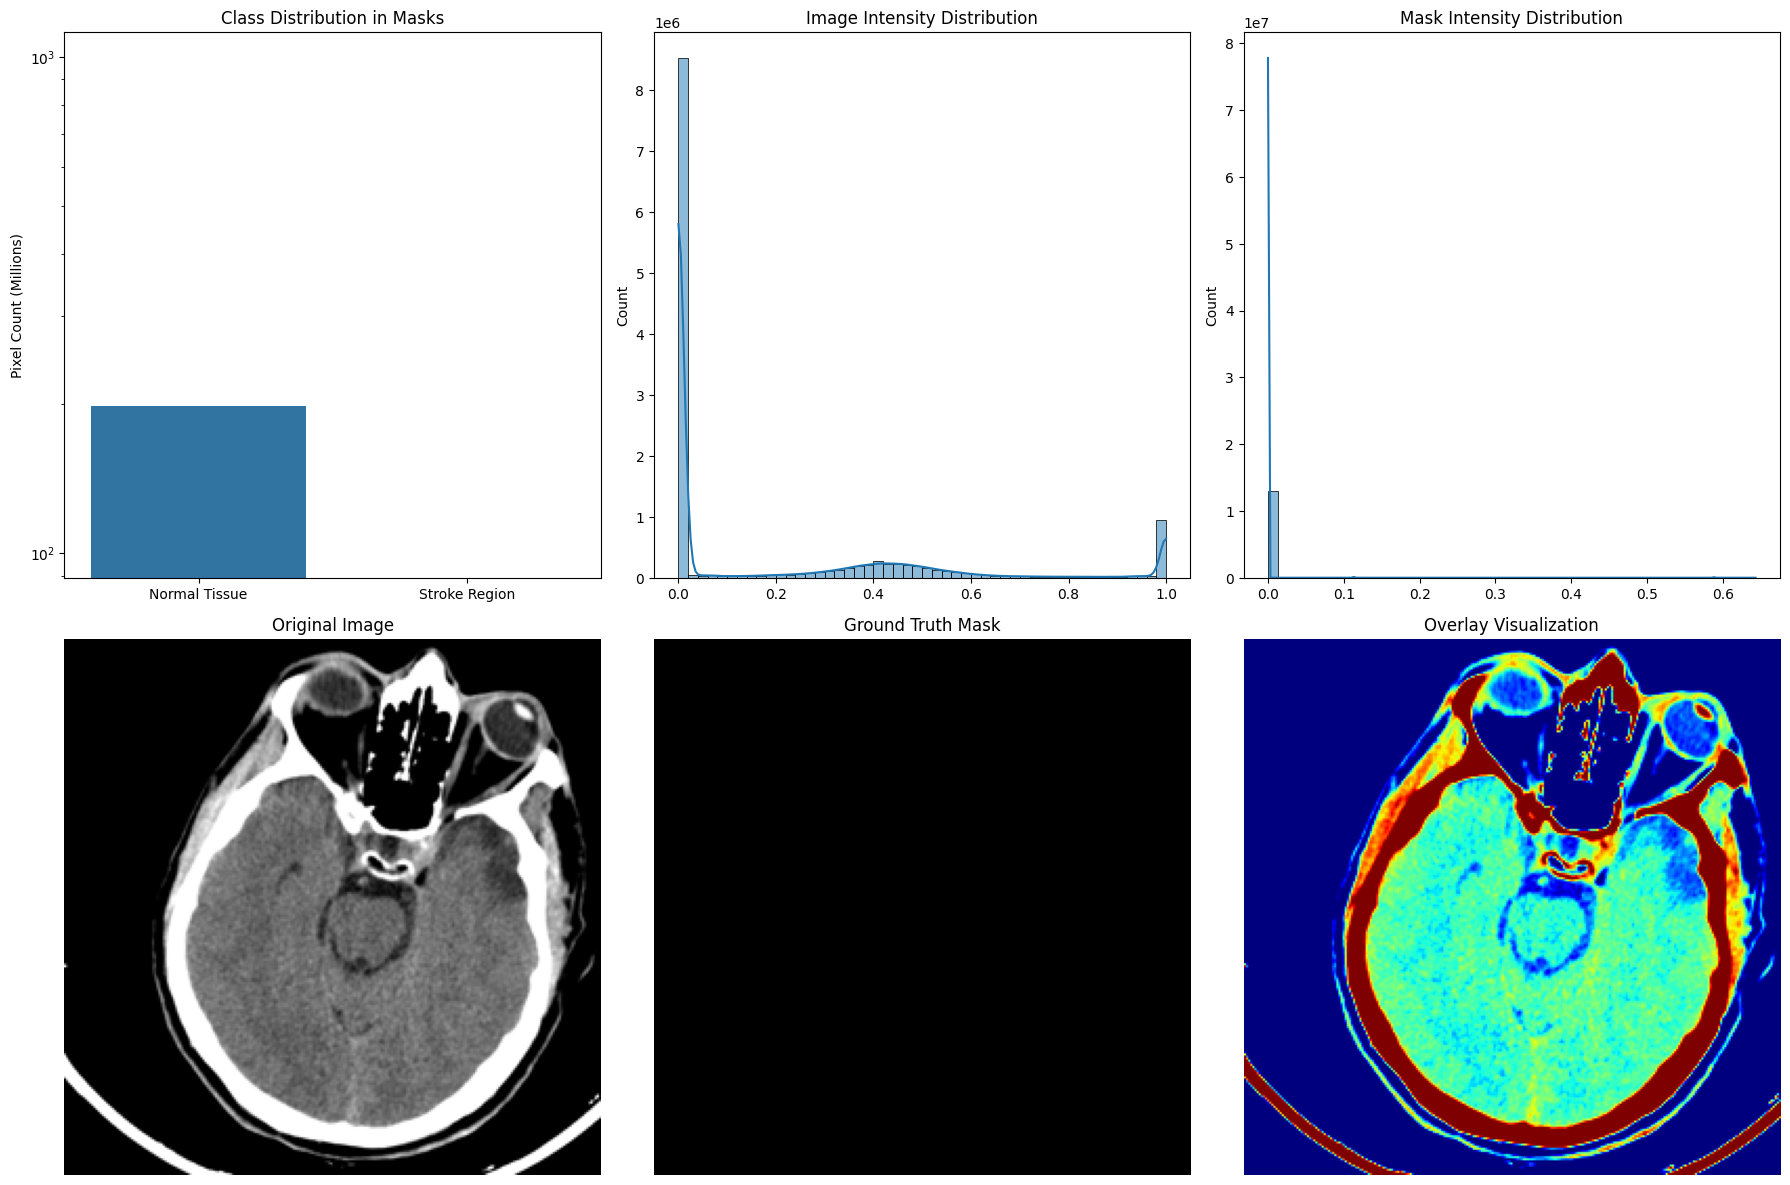

In [ ]:
!pip install seaborn
import seaborn as sns # Import seaborn library

# Enhanced Data Visualization
def plot_data_distribution():
    plt.figure(figsize=(18, 12))

    # Class distribution
    plt.subplot(2, 3, 1)
    class_counts = {
        'Normal Tissue': np.sum([np.mean(mask == 0) for mask in masks]),
        'Stroke Region': np.sum([np.mean(mask == 1) for mask in masks])
    }
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values())) # Use sns.barplot after importing seaborn
    plt.title("Class Distribution in Masks")
    plt.ylabel("Pixel Count (Millions)")
    plt.yscale('log')

    # Image intensity distribution
    plt.subplot(2, 3, 2)
    sample_image = np.concatenate([img.flatten() for img in images])
    sns.histplot(sample_image, bins=50, kde=True)
    plt.title("Image Intensity Distribution")

    # Mask intensity distribution
    plt.subplot(2, 3, 3)
    sample_mask = np.concatenate([mask.flatten() for mask in masks])
    sns.histplot(sample_mask, bins=50, kde=True)
    plt.title("Mask Intensity Distribution")
      # Sample overlay visualization
    plt.subplot(2, 3, 4)
    idx = np.random.randint(len(images))
    plt.imshow(images[idx].squeeze(), cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.imshow(masks[idx].squeeze(), cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.subplot(2, 3, 6)
    overlay = cv2.addWeighted(images[idx].squeeze(), 0.7, masks[idx].squeeze(), 0.3, 0)
    plt.imshow(overlay, cmap='jet')
    plt.title("Overlay Visualization")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

plot_data_distribution()

In [ ]:
# Enhanced Model Complexity Analysis
def analyze_model_complexity(model):
    print("\n\033[1m=== Model Complexity Analysis ===\033[0m")

    # Calculate FLOPs
    try:
        from tensorflow.python.profiler.model_analyzer import profile
        from tensorflow.python.profiler.option_builder import ProfileOptionBuilder
        flops = profile(tf.profiler.experimental.ProfilerOptions(),
                        options=ProfileOptionBuilder.float_operation())
        print(f"Estimated FLOPs: {flops.total_float_ops / 1e9:.2f} GFLOPs")
    except Exception as e:
        print("FLOPs calculation failed:", e)

    # Parameter breakdown
    trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
    non_trainable_params = np.sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])
    print(f"Trainable Parameters: {trainable_params:,}")
    print(f"Non-trainable Parameters: {non_trainable_params:,}")

    # Layer-wise complexity
    print("\nLayer-wise Parameter Distribution:")
    for layer in model.layers:
        params = layer.count_params()
        if params > 0:
            print(f"{layer.name:20} {params:>12,} ({params/trainable_params*100:.1f}%)")

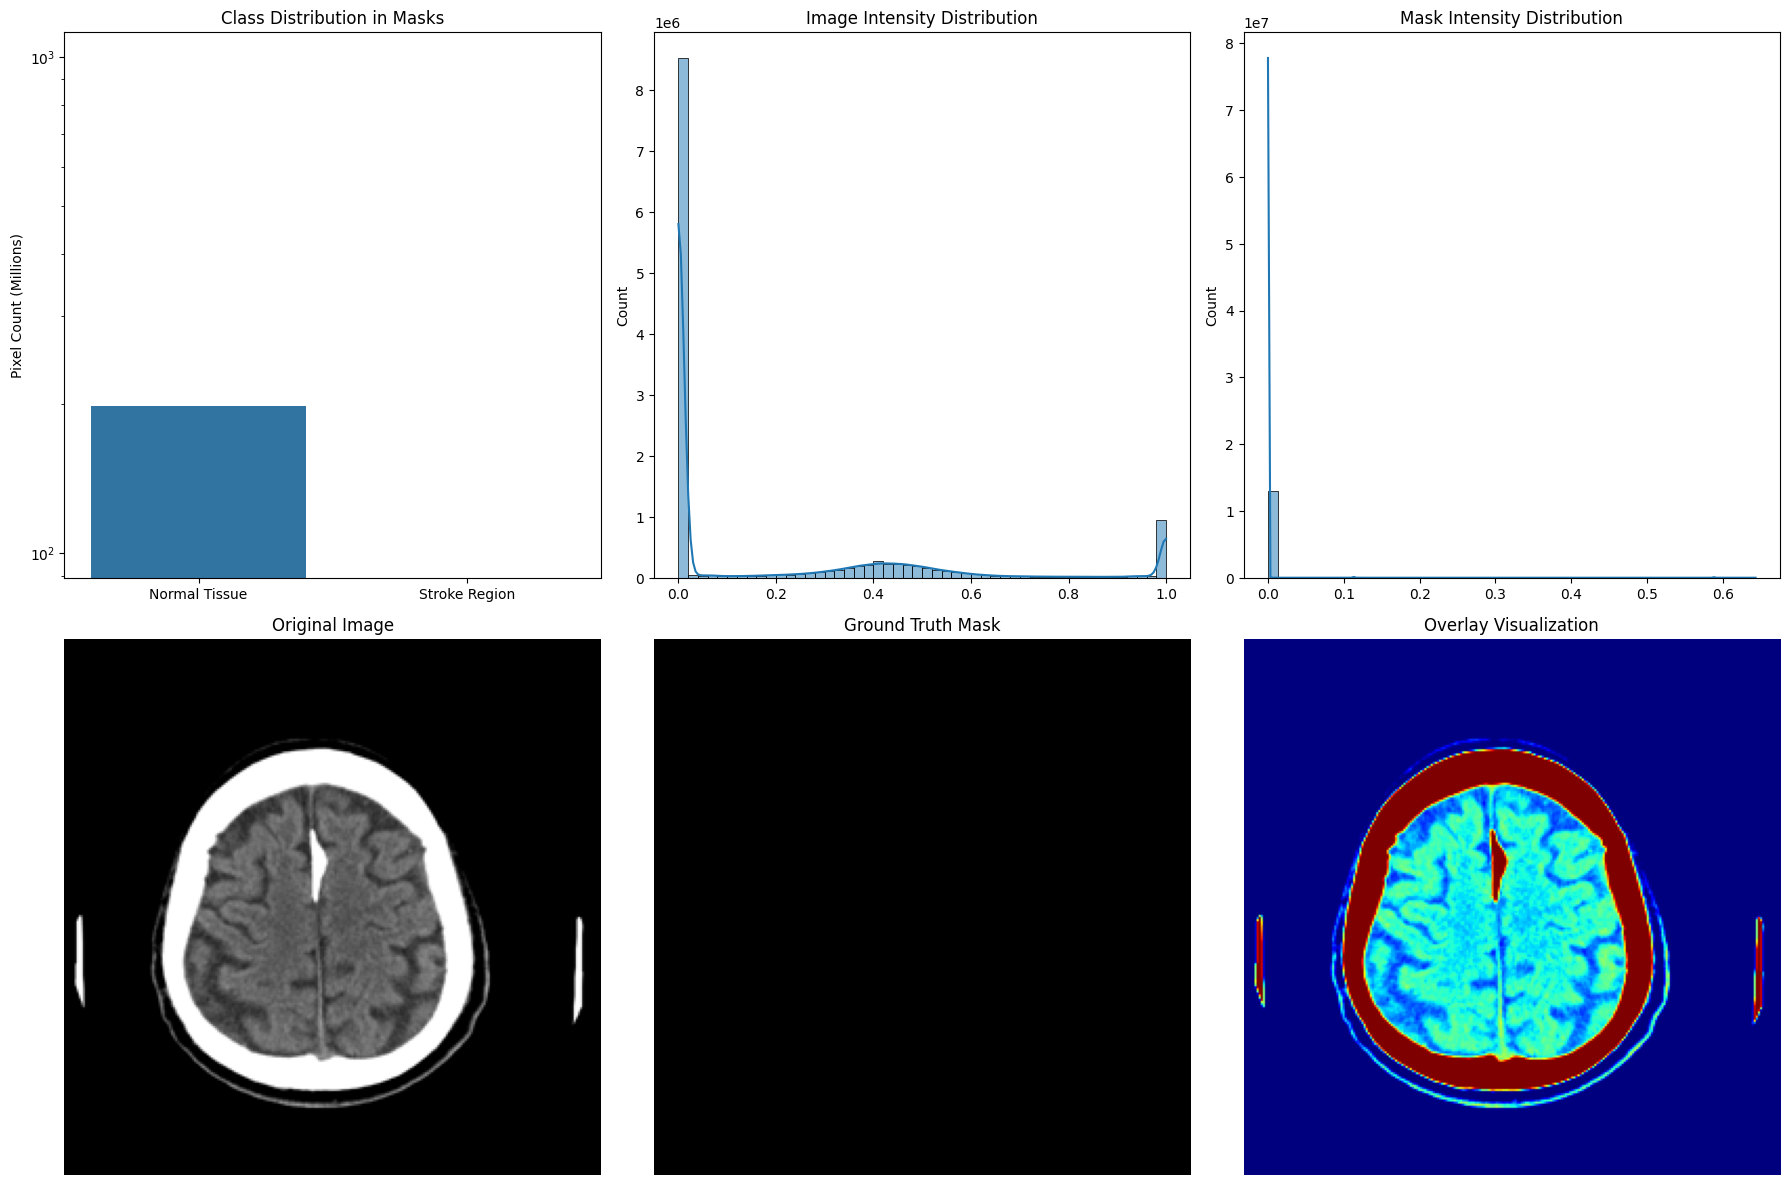

In [ ]:
class TrainingVisualizer(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 2 == 0:
            self.plot_predictions(epoch) # Pass epoch to plot_predictions

    def plot_predictions(self, epoch): # Accept epoch as argument
        sample_idx = np.random.randint(len(X_val))
        prediction = self.model.predict(X_val[sample_idx][np.newaxis, ...])

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(X_val[sample_idx].squeeze(), cmap='gray')
        plt.title("Input Image")

        plt.subplot(1, 3, 2)
        plt.imshow(y_val[sample_idx].squeeze(), cmap='gray')
        plt.title("Ground Truth")

        plt.subplot(1, 3, 3)
        plt.imshow(prediction.squeeze() > 0.5, cmap='gray')
        plt.title("Model Prediction")

        plt.suptitle(f"Epoch {epoch} Prediction Example") # Use the passed epoch value
        plt.show()
plot_data_distribution()

In [ ]:
!pip install gradio --quiet


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set paths to dataset directories
import os

base_path = '/content/drive/MyDrive/Dataset'  # Adjust if your folder is nested deeper
ct_path = os.path.join(base_path, 'Brain Tumor CT scan')
mri_path = os.path.join(base_path, 'Brain Tumor MRI images')

print("CT Dataset Path:", ct_path)
print("MRI Dataset Path:", mri_path)


Mounted at /content/drive
CT Dataset Path: /content/drive/MyDrive/Dataset/Brain Tumor CT scan
MRI Dataset Path: /content/drive/MyDrive/Dataset/Brain Tumor MRI images


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

In [ ]:
# Training and validation data generators for MRI
# Define img_height and img_width
img_height, img_width = 224, 224 # Set your desired image size

# Define batch_size here
batch_size = 32  # You can adjust this value

train_mri = datagen.flow_from_directory(
    mri_path,
    target_size=(img_height, img_width),
    batch_size=batch_size, # Now batch_size is defined
    class_mode='binary',
    subset='training'
)

val_mri = datagen.flow_from_directory(
    mri_path,
    target_size=(img_height, img_width),
    batch_size=batch_size, # Now batch_size is defined
    class_mode='binary',
    subset='validation'
)

Found 4078 images belonging to 2 classes.
Found 1018 images belonging to 2 classes.


<ipython-input-9-af47e666c245>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='label', palette='viridis')


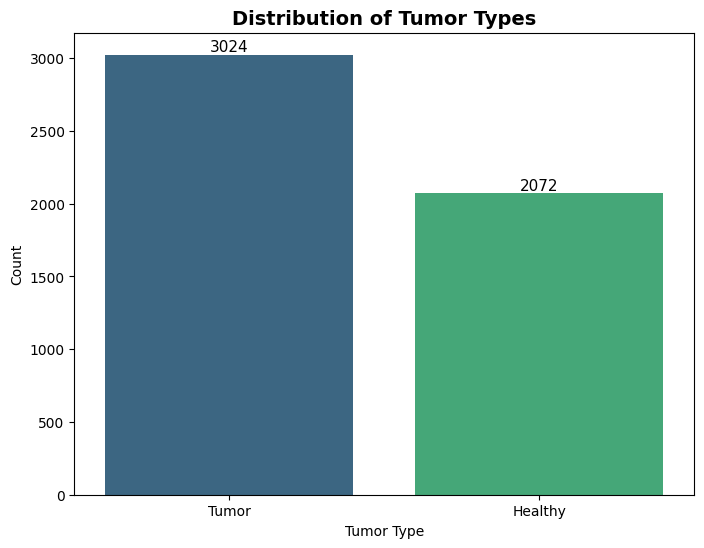

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

# Build filepaths and labels
categories = ['Tumor', 'Healthy']
image_paths = []
labels = []

for category in categories:
    category_path = os.path.join(mri_path, category)
    for image_name in os.listdir(category_path):
        if image_name.lower().endswith(('jpg', 'jpeg', 'png')):
            image_paths.append(os.path.join(category_path, image_name))
            labels.append(category)

# Create dataframe
df = pd.DataFrame({'image_path': image_paths, 'label': labels})

# Plot bar chart
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='label', palette='viridis')
plt.title("Distribution of Tumor Types", fontsize=14, fontweight='bold')
plt.xlabel("Tumor Type")
plt.ylabel("Count")

for p in plt.gca().patches:
    plt.text(p.get_x() + p.get_width()/2., p.get_height(), f'{int(p.get_height())}',
             ha='center', va='bottom', fontsize=11)

plt.show()


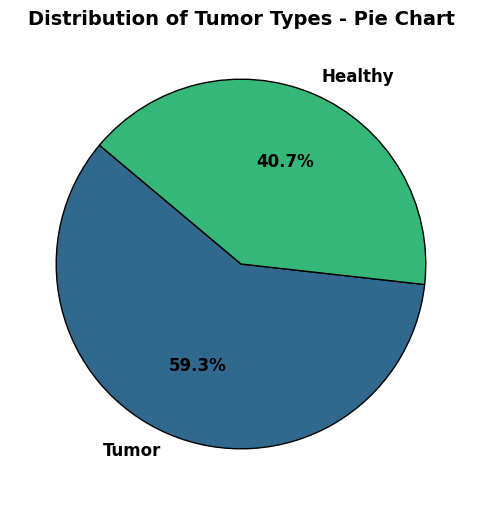

In [ ]:
label_counts = df['label'].value_counts()
colors = sns.color_palette("viridis", len(label_counts))

plt.figure(figsize=(8, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140,
        colors=colors, textprops={'fontsize': 12, 'weight': 'bold'},
        wedgeprops={'edgecolor': 'black', 'linewidth': 1})
plt.title("Distribution of Tumor Types - Pie Chart", fontsize=14, fontweight='bold')
plt.show()


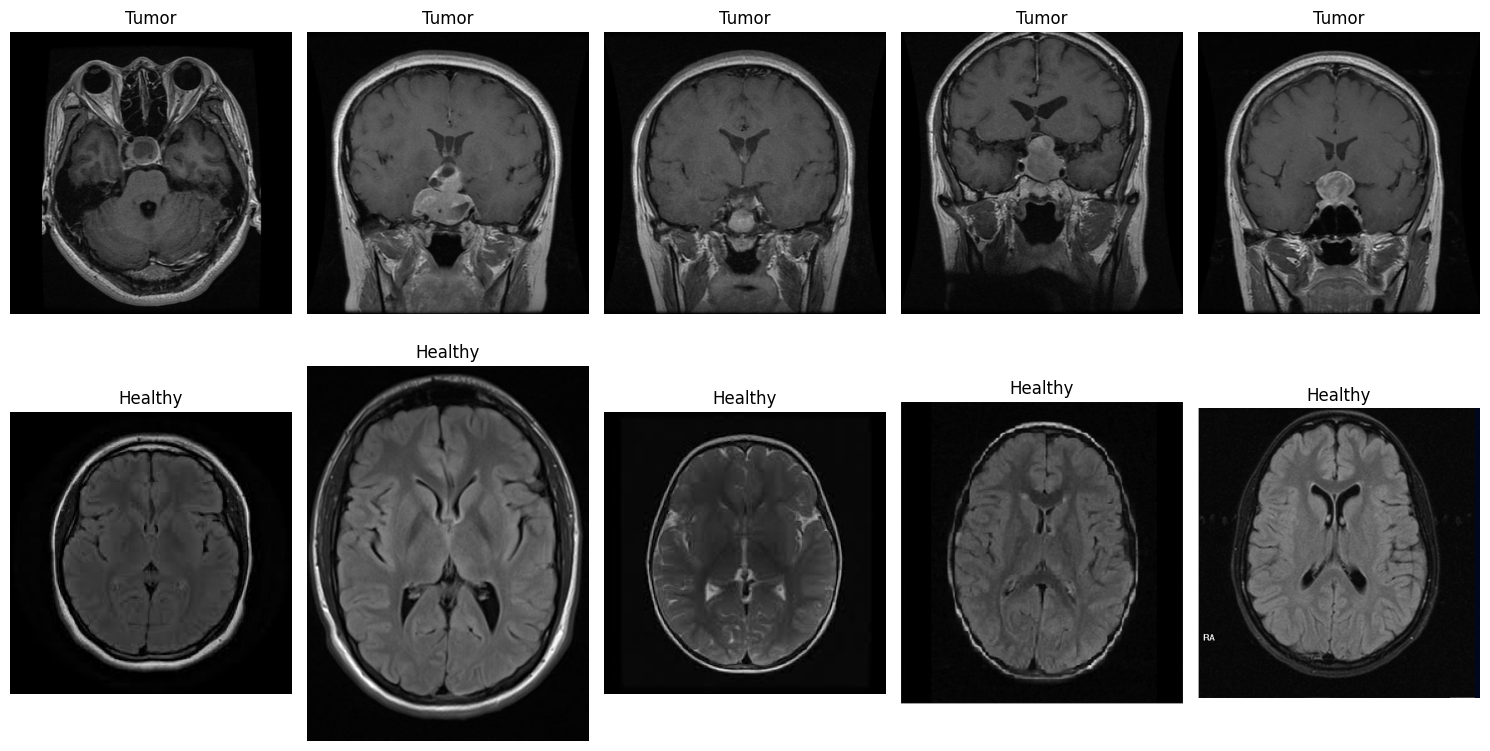

In [ ]:
import cv2

def plot_sample_images(df, categories, num_images=5):
    plt.figure(figsize=(15, 8))
    for i, category in enumerate(categories):
        images = df[df['label'] == category]['image_path'].iloc[:num_images]
        for j, img_path in enumerate(images):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(len(categories), num_images, i * num_images + j + 1)
            plt.imshow(img)
            plt.title(category)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_sample_images(df, categories)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Step 5: CNN Model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Step 6: Model Training
history = model.fit(
    train_mri,
    steps_per_epoch=train_mri.samples // batch_size,
    validation_data=val_mri,
    validation_steps=val_mri.samples // batch_size,
    epochs=10
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 686s 5s/step - accuracy: 0.6214 - loss: 0.6684 - val_accuracy: 0.7671 - val_loss: 0.5027
Epoch 2/10
  1/127 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.8438 - loss: 0.3044

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - accuracy: 0.8438 - loss: 0.3044 - val_accuracy: 0.7268 - val_loss: 0.5925
Epoch 3/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 141s 831ms/step - accuracy: 0.8439 - loss: 0.3819 - val_accuracy: 0.8085 - val_loss: 0.4421
Epoch 4/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 20s 158ms/step - accuracy: 0.8750 - loss: 0.3547 - val_accuracy: 0.8125 - val_loss: 0.4145
Epoch 5/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 102s 669ms/step - accuracy: 0.8778 - loss: 0.3056 - val_accuracy: 0.8558 - val_loss: 0.3467
Epoch 6/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 0.9688 - loss: 0.1514 - val_accuracy: 0.8639 - val_loss: 0.3207
Epoch 7/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 125s 663ms/step - accuracy: 0.9038 - loss: 0.2565 - val_accuracy: 0.9022 - val_loss: 0.2720
Epoch 8/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 18s 146ms/step - accuracy: 0.9062 - loss: 0.2428 - val_accuracy: 0.8931 - val_loss: 0.2823
Epoch 9/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 140s 793ms/step - accuracy: 0.9168 - loss: 0.2256 -

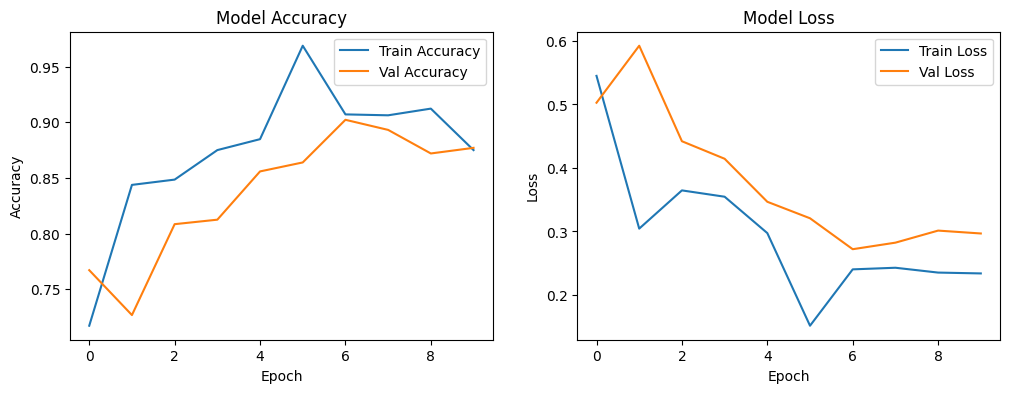

In [ ]:
# Step 7: Accuracy & Loss Plots
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 507ms/step


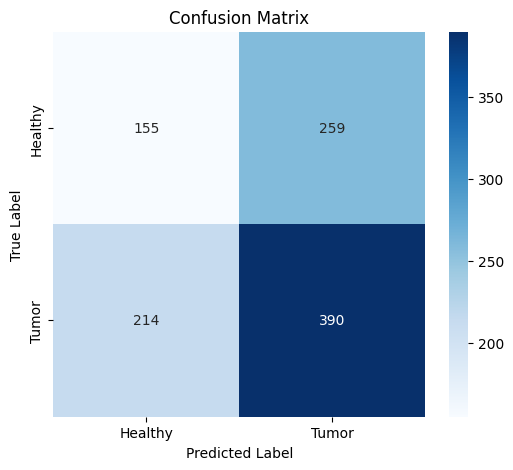

In [ ]:
from sklearn.metrics import confusion_matrix

val_mri.reset()  # Use val_mri instead of val_data
pred = model.predict(val_mri)
y_pred = (pred > 0.5).astype(int).reshape(-1)
y_true = val_mri.classes

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=val_mri.class_indices,  # Use val_mri instead of val_data
            yticklabels=val_mri.class_indices)  # Use val_mri instead of val_data
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Step 8: Evaluation
val_mri.reset()
pred = model.predict(val_mri, steps=val_mri.samples // batch_size, verbose=1)
predictions = (pred > 0.5).astype(int)

print("Classification Report:")
print(classification_report(val_mri.classes[:len(predictions)], predictions))

# ... (rest of the code)

31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 483ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.38      0.41       414
           1       0.59      0.64      0.61       578

    accuracy                           0.53       992
   macro avg       0.51      0.51      0.51       992
weighted avg       0.52      0.53      0.53       992



In [ ]:
!pip install gradio --quiet


In [ ]:
import gradio as gr
import cv2
import numpy as np

def predict_with_gradio(img):
    # Convert PIL image to NumPy array
    img = np.array(img)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    prediction = model.predict(img)[0][0]
    label = "Tumor" if prediction > 0.5 else "No Tumor"
    confidence = f"{prediction:.2f}" if prediction > 0.5 else f"{1 - prediction:.2f}"

    return f"{label} ({confidence} confidence)"


In [ ]:
interface = gr.Interface(
    fn=predict_with_gradio,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Brain Tumor Detector",
    description="Upload an MRI or CT scan to detect Tumor presence",
    theme="default"
)

interface.launch(share=True)  # Set share=False if you don't need a public link


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ee08075fca5b46a1cd.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
